In [212]:
import json
import numpy as np

from lttb import LTTB

from env import Unlock

from tqdm import tqdm, trange
from itertools import product as Prod

# ============= TEST FUNCTION =================
def test (lttb, env, testset, par):
    rt, rb = r = (par['rt'], par['rb'])
    size = np.shape(testset)[-1]

    hist = {'agent'  : np.zeros ((size, par['T'], 2)),
            'action' : np.zeros ((size, par['T'], par['O'])),
            'theta'  : np.zeros (size),
            'R'      : np.zeros (size)}

    tars = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in testset])
    btns =  [(0., rb)] * len (testset)

    for i, (targ, btn) in enumerate (zip (tars, btns)):
        env.reset (init = init, targ = targ, btn = btn)
        lttb.initialize(par)
        R = 0

        state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

        for t in range (par['T']):
            action, _ = lttb.step (apicalFactor =0)
            state, r, done, agen = env.step (action)

            R = max (R, r)

            hist['action'][i, t] = action
            hist['agent'][i, t]  = agen

            if done: break

        hist['action'][i, t:] = np.nan
        hist['agent'][i, t:]  = agen
        hist['theta'][i]      = testset[i]
        hist['R'][i]          = R

    return hist

In [213]:
"""
sigma_in = 5
!!! -> fare test su tutti angoli 0-360, calcolare R come distanza minima tra bottone e array posizioni, poi fare plot e
   sovrapporre angoli di training
-> sparsificare l'input e/o il contesto
-> provare reaching studiando di piu' o diminuendo il numero di esempi (n_context=20 usato in due punti diversi del codice)
-> l'esperto raggiunge il bottone sempre a t=60, ovunque il bottone sia; questo implica velocita' diverse;
   possiamo o settare la velocita' ad una costante, quindi cambiando il tempo di reach del bottone, o semplicemente estrarre
   i bottoni su una circonferenza di raggio fissato
"""

"\nsigma_in = 5\n-> sparsificare l'input e/o il contesto\n-> provare reaching studiando di piu' o diminuendo il numero di esempi (n_context=20 usato in due punti diversi del codice)\n-> l'esperto raggiunge il bottone sempre a t=60, ovunque il bottone sia; questo implica velocita' diverse;\n   possiamo o settare la velocita' ad una costante, quindi cambiando il tempo di reach del bottone, o semplicemente estrarre\n   i bottoni su una circonferenza di raggio fissato\n"

In [214]:
# Loading configuration file
path = 'config.json'
config = 'BUTTON_FOOD'

with open (path, 'r') as f:
    par = json.load (f)[config]

par['hint'] = par['hint'] == 'True'
par['clump'] = par['clump'] == 'True'
par['validate'] = par['validate'] == 'True'
par['verbose'] = par['verbose'] == 'True'

# ==== Environment Initialization ======
init = np.array ((0., 0.))
targ = np.array ((0., 1.))
btn = np.array ((0., 0.))

env = Unlock (init = init, targ = targ, btn = btn, unit = (par['dt'], par['dx']), res = 20)

rt, rb = par['rt'], par['rb']

trainset = np.array (par['trainset'])
validset = np.array (par['validset'])
testset  = np.linspace (*par['testset'])

train_theta = trainset * np.pi / 180.
valid_theta = validset * np.pi / 180.
test_theta  = testset * np.pi / 180.

#train_targs = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in train_theta])

train_targs = (np.random.rand(20,2)-.5)*2#np.array ([( np.random.rand(1) , np.random.rand(1) ) for t in train_theta])
train_thetas = [random.random()*2*np.pi for i in range(20)]
train_bttns = np.array ([(1 * np.cos (t), 1 * np.sin (t)) for t in train_thetas])
#train_bttns = (np.random.rand(20,2)-.5)*2#np.array ([(0, rb) for t in train_theta])

#valid_targs = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in valid_theta])


In [215]:
np.shape(train_targs)

(20, 2)

In [216]:

#valid_bttns = np.array ([(rb * np.cos (t), rb * np.sin (t)) for t in valid_theta])

tb = 60
tf = 60

# Here we ask the env for the expert behaviour
epar = {'offT' : (1, 1), 'steps' : (tb-1, tf-1), 'T' : (tb, tf)}
train_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (train_targs, train_bttns)]
#valid_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (valid_targs, valid_bttns)]



In [217]:
train_bttns

array([[-0.81469127,  0.57989493],
       [ 0.56563645,  0.82465472],
       [ 0.41695027,  0.9089293 ],
       [-0.99039982,  0.13823243],
       [ 0.97342864,  0.22899058],
       [ 0.7849496 ,  0.61955963],
       [-0.08148506,  0.99667456],
       [ 0.78334784,  0.62158359],
       [ 0.52172434, -0.85311413],
       [-0.13604672, -0.99070242],
       [-0.71346322, -0.70069268],
       [ 0.99758805, -0.06941241],
       [-0.95781031,  0.28740112],
       [ 0.99245548, -0.12260552],
       [ 0.57569031, -0.81766782],
       [ 0.59886034, -0.80085348],
       [ 0.16706774,  0.98594542],
       [ 0.7134034 , -0.70075359],
       [-0.66233076, -0.74921156],
       [ 0.29928075, -0.9541651 ]])

In [218]:
import numpy as np

import matplotlib.pyplot as plt

from tqdm import trange
import random


N, I, O, T = 500, 80, 2, tb+tf
shape = (N, I, O, T)

dt = .001
tau_m = 20. * dt
tau_s = 2. * dt
tau_ro = 10. * dt
tau_star = 20. * dt
tau_W = 200 * dt


beta = np.exp(-dt/tau_s)
beta_ro = np.exp(-dt/tau_ro)
beta_targ = np.exp(-dt/tau_star)
beta_W = np.exp(-dt/tau_W)

sigma_context = 40.
sigma_targ = 0.#10**1.5
sigma_in = 20.#12.

dv = 1 / 500.
alpha = .005
alpha_rout = .01
Vo = - 4
h = - 1
s_inh = 20

sigma_Jrec = 0.
sigma_wrec = 0.
sigma_Jout = 0.1

Ne = 400
Ni = 100

N = Ne+Ni

n_contexts = 20

# Here we build the dictionary of the simulation parameters
par = {'dt' : dt, 'tau_m' : tau_m, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'tau_star' : tau_star,'tau_W' : tau_W,
       'dv' : dv, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
       'N' : N, 'Ni' : Ni, 'Ne' : Ne, 'T' : T, 'I' : I, 'O' : O, 'shape' : shape, 
       'sigma_Jrec' : sigma_Jrec,'sigma_wrec' : sigma_wrec, 'sigma_Jout' : sigma_Jout,  'n_contexts' : n_contexts,
       'alpha' : alpha, 'alpha_rout' : alpha_rout,
       'sigma_in' : sigma_in, 'sigma_targ' : sigma_targ, 'sigma_context' : sigma_context, 'h' : h}

TIME = 1.

T = int(np.floor(TIME/dt))

nStepOutTraining = 1000

t_shut = 2

JMAX = 100.
nu_targ = 0.005

# Here we init our (recurrent) agent
lttb = LTTB (par)


In [219]:
# define clock and target

lttb.y_targ_collection = []
lttb.I_clock_collection = []

for k in range(n_contexts):
    print(k)
    lttb.y_targ_collection.append(train_exp[k][1])
    lttb.I_clock_collection.append( train_exp[k][0] )
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


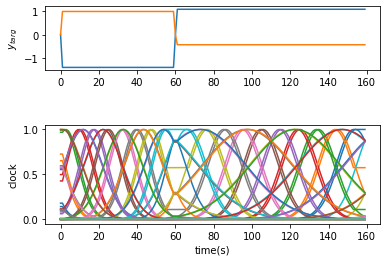

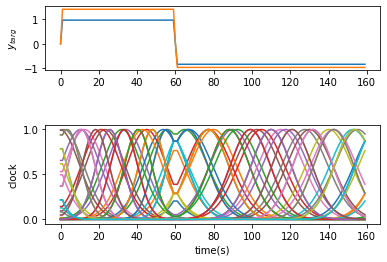

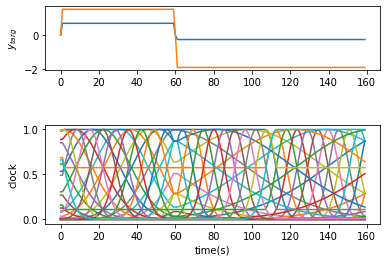

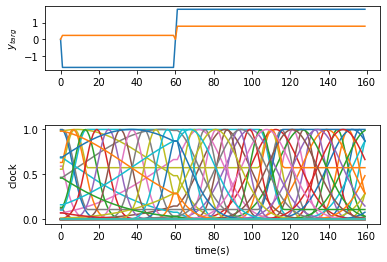

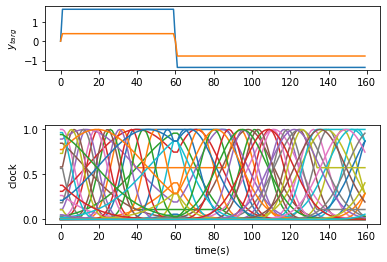

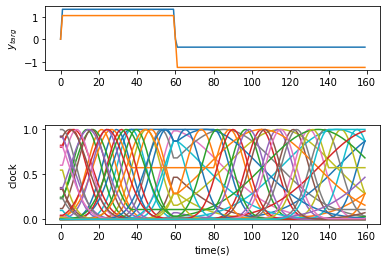

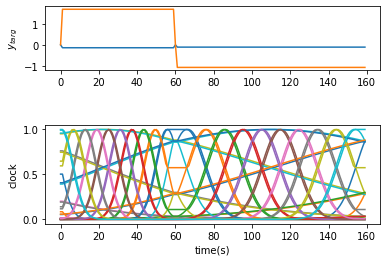

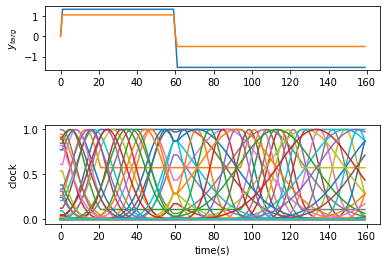

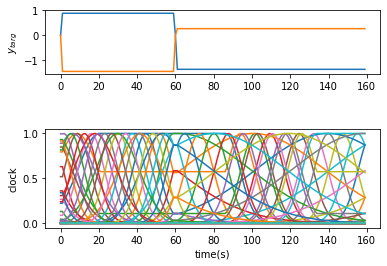

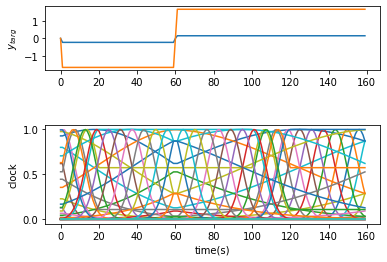

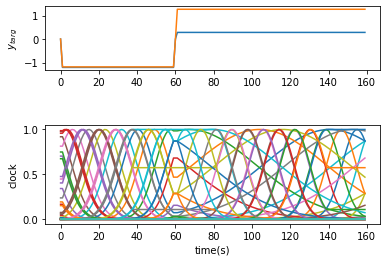

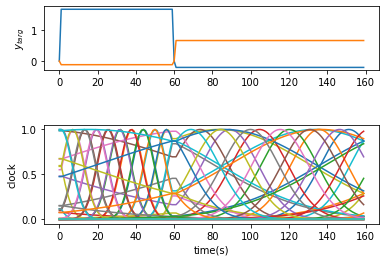

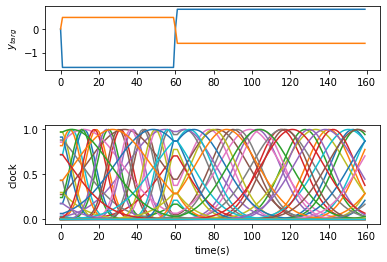

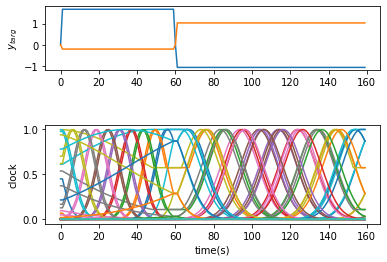

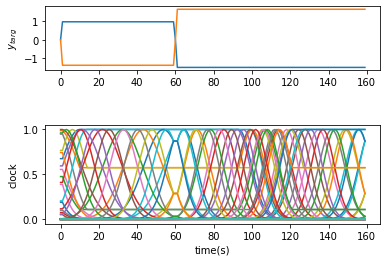

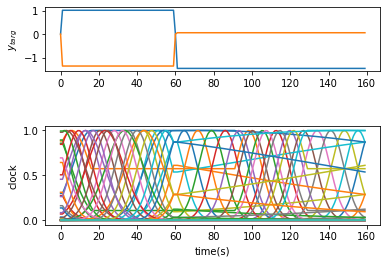

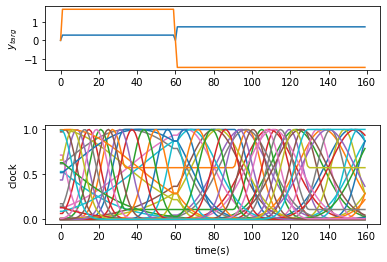

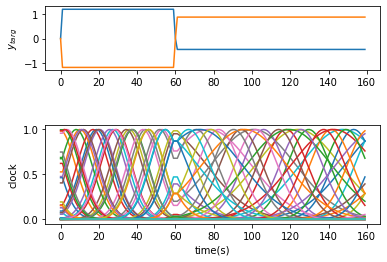

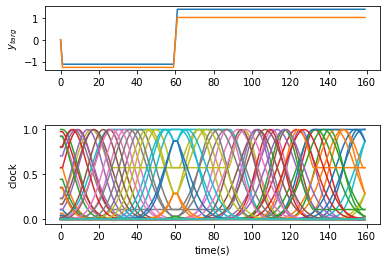

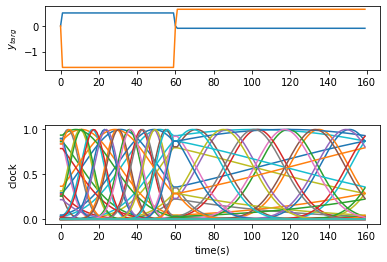

In [220]:
for k in range(n_contexts):

    plt.figure()
    plt.subplot(311)
    plt.plot(np.array(lttb.y_targ_collection[k]).T)
    plt.ylabel('$y_{targ}$')
    plt.subplot(212)
    plt.plot(np.array(lttb.I_clock_collection[k]).T)
    plt.xlabel('time(s)')
    plt.ylabel('clock')

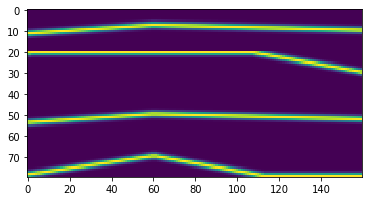

In [221]:
plt.imshow(np.array(lttb.I_clock_collection[2]))


In [222]:
## Training Rec
par['T'] = 160
lttb.T = 160
    
gamma = 10.
def f(x,gamma):
    return np.exp(x*gamma)/(np.exp(x*gamma)+1)
#f1 = @(x)(gamma*exp(gamma*x))./(exp(gamma*x)+1)-(gamma*exp(2*gamma*x))./(exp(gamma*x)+1).^2;

apicalFactorTrain = 1
apicalFactorTest = 0

nIterRec = 50

eta = 0.
eta_out = 0.01
etaW = .0

for iter in range(nIterRec):
    
    ###### Online-Training

    #initialize simulation
    
    for cont_index in range(n_contexts):
        
        
        lttb.initialize(par)
        lttb.y_targ = lttb.y_targ_collection[cont_index]
        lttb.I_clock = lttb.I_clock_collection[cont_index]
        
        lttb.cont = lttb.cont*0
        lttb.cont[0] = 1

        #run simulation
        dH = 0

        #for t in range(lttb.T-2):
        for t in range(tb-2):
            
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1
                
            lttb.step(apicalFactor = apicalFactorTrain)
            
            SR = lttb.B_filt[:,t+1]#lttb.S_filtRO[:,t+1]#
            Y = lttb.Jout@SR
            DJRO = np.outer(lttb.y_targ[:,t+1] - Y,SR.T)
            lttb.Jout =  lttb.Jout + eta_out*DJRO
        
    ###### Test
    
    if iter%5==0:

        for cont_index in range(n_contexts):
            
            lttb.initialize(par)
            lttb.y_targ = lttb.y_targ_collection[cont_index]
            lttb.I_clock = lttb.I_clock_collection[cont_index]
            
            
            lttb.cont = lttb.cont*0
            lttb.cont[0] = 1

            #run simulation

            #for t in range(lttb.T-2):
            for t in range(tb-2):
                
                if t==tb:
                    lttb.cont = lttb.cont*0
                    lttb.cont[1] = 1
                
                lttb.step(apicalFactor = apicalFactorTest)

            SR = lttb.B_filt[:,1:-2]#lttb.S_filtRO[:,1:-2]# 
            Y = lttb.Jout@SR
            mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

            print(mse_rec_train)
            

0.9809302193568115
0.9670224947222037
1.572953996253189
1.5226312405044944
1.1152605677116474
0.9869549080331343
0.9086511435118618
1.2329631644483372
0.8138887109279533
1.3619656459702798
1.064000695482333
0.4249556660582565
0.9028463433654514
1.0825865022994439
1.975506345340795
0.8230242555204663
1.3334955237942547
0.7264379837208625
1.3918812103332847
0.6091945534094372
0.9480194027244313
0.8270585347363644
1.4559418308615808
1.504988193484333
0.9421070675630492
0.8291804037412928
0.8382814251072029
1.083698072394057
0.6234928222679346
1.298135382761387
1.000729584850143
0.3223357810065614
0.8920169257049094
0.9551827137796625
1.7841891067037692
0.6110989626778378
1.257859304085647
0.5559553935700652
1.303118823240712
0.49316918633685164
0.8368387716315305
0.7233109682536866
1.3565421931248027
1.3870589699899307
0.8657436857280624
0.7332833304742199
0.7372984348990692
0.9936265105259853
0.5555459116465222
1.250088260556797
0.9047736422016377
0.2975108044572676
0.7976538610068972
0.

In [223]:
np.shape(Y)

(2,)

In [224]:
lttb.T

160

0.6152704401683556


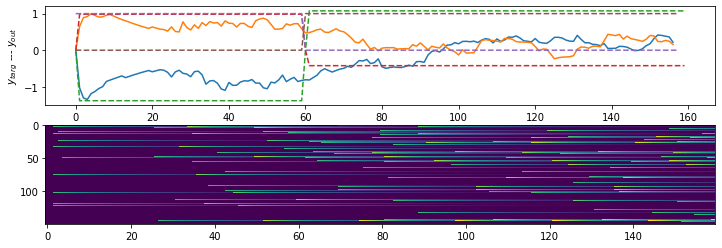

0.635432967973428


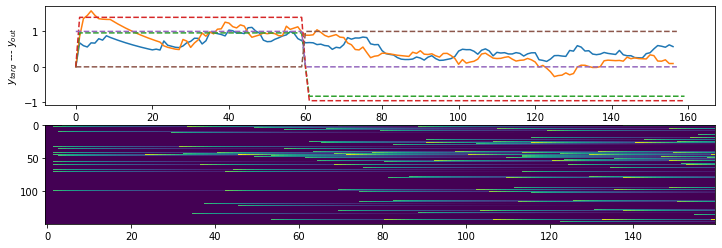

1.4946112278130514


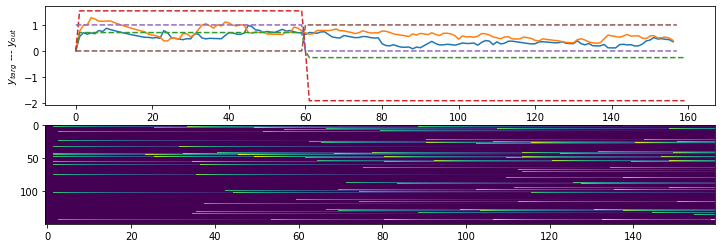

1.0892629107810547


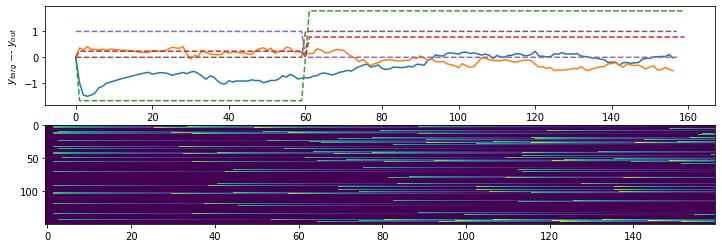

1.1058860436846099


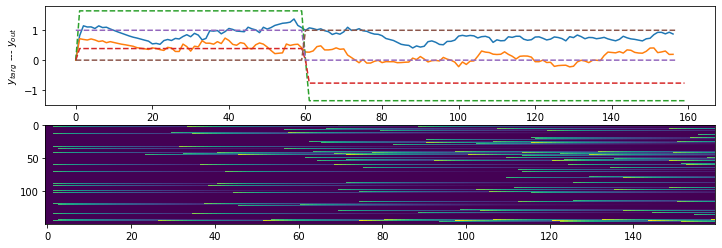

0.6930584552776213


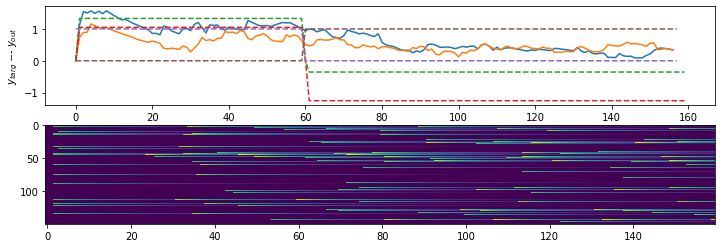

0.7067084118460085


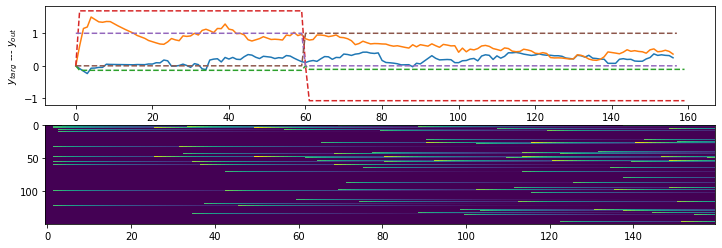

1.2072053463177734


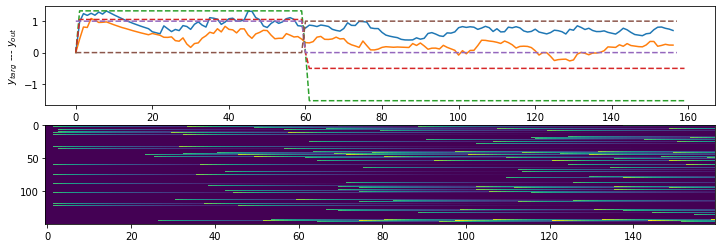

1.256610002158317


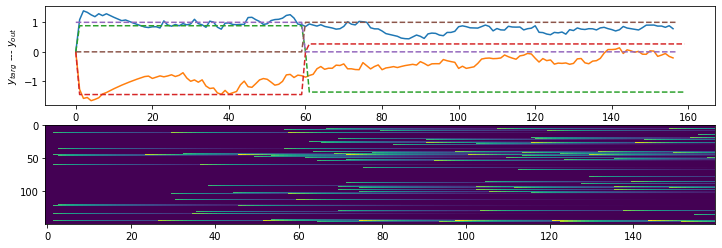

1.1653946196210359


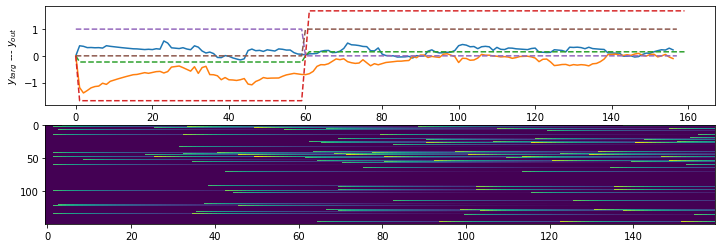

0.7969345371904983


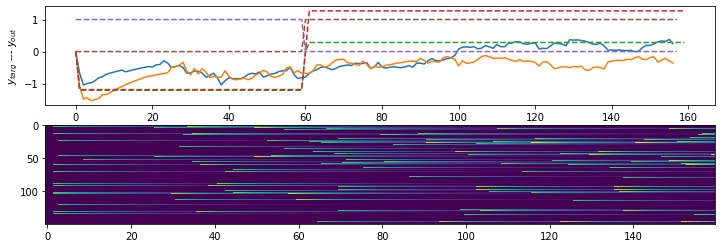

0.41725085645390364


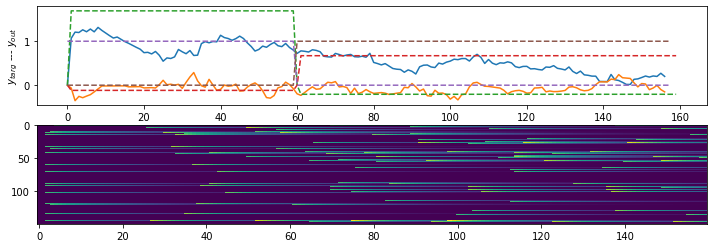

0.515087178527895


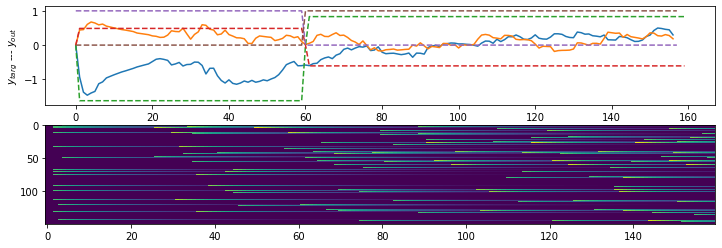

1.3199443326450928


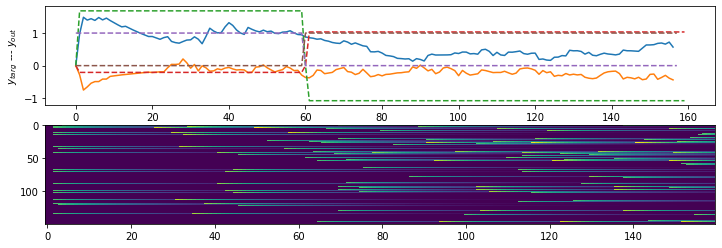

2.6012587324616137


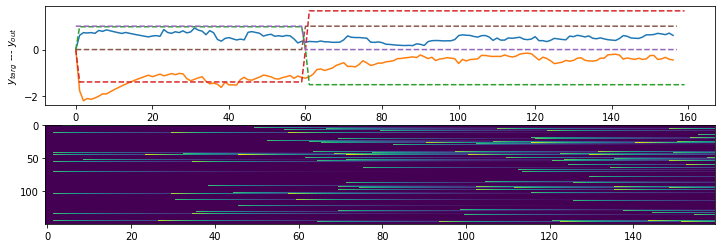

1.2831879356427065


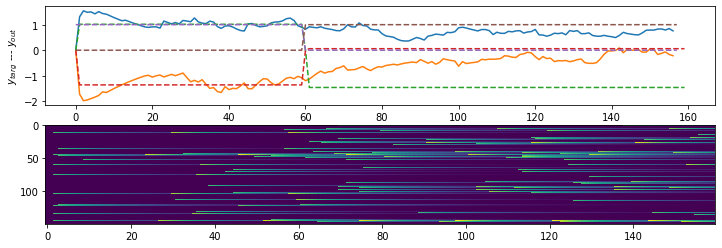

1.181708095551924


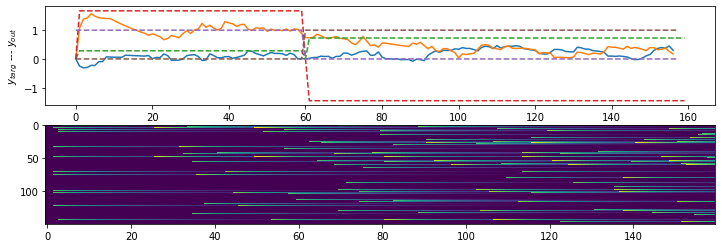

0.6043334635598216


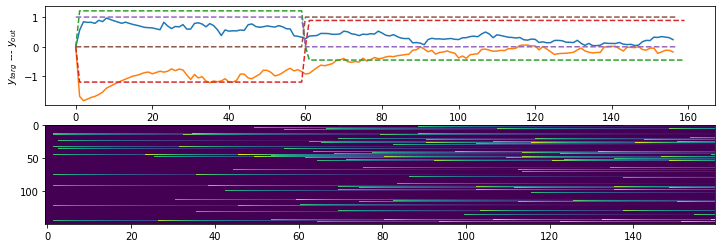

0.8277923922030933


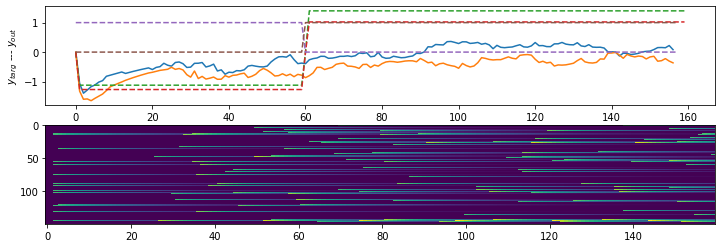

0.5447713927930744


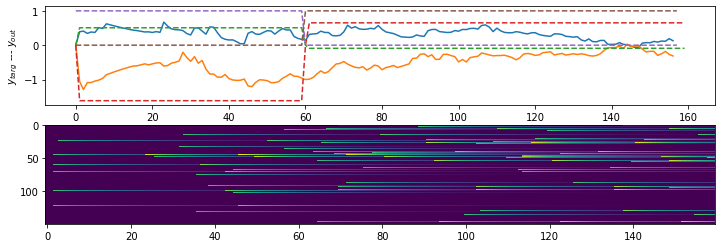

In [225]:
for cont_index in range(n_contexts):
    
    context = []

    lttb.initialize(par)
    lttb.I_clock = lttb.I_clock_collection[cont_index]
    lttb.y_targ = lttb.y_targ_collection[cont_index]
    
    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    #run simulation
    
    apicalFactor = 0
    
    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    for t in range(lttb.T-2):
 
        if t==tb:
           
            lttb.cont = lttb.cont*0
            lttb.cont[1] = 1
        context.append(lttb.cont)
        
        lttb.step(apicalFactor = apicalFactor)

    SR = lttb.B_filt[:,1:-2]#lttb.S_filtRO[:,1:-2]#
    Y = lttb.Jout@SR
    mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

    print(mse_rec_train)
    
#mse, Y = lttb.train_ro(par,out_epochs = 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(211)
    plt.plot(Y.T)
    plt.plot(lttb.y_targ.T,'--')
    plt.plot(np.array(context),'--')
    
    plt.xlabel('time(s)')
    plt.ylabel('$y_{targ}$ --- $y_{out}$')
    plt.subplot(212)
    plt.imshow(lttb.B_filt[0:150,:],aspect='auto')
    #plt.plot(lttb.B_filt_rec.T)
    
    #plt.subplot(313)
    #plt.imshow(lttb.S_wind[0:20,:],aspect='auto')
    
    plt.show()

In [295]:
def make_test(btn_theta, show_plot=True):
    
    TIME_TEST = 500
    cont_index = 6

    par['T'] = TIME_TEST
    lttb.T = TIME_TEST
    lttb.initialize(par)

    lttb.y_targ = np.zeros((lttb.O,lttb.T))

    targ_test = train_targs[cont_index]
    btn_test = train_bttns[cont_index]

    #theta = 30
    #theta = theta/180*np.pi
    targ_test = (np.random.rand(2)-.5)
    #btn_test = (np.random.rand(2)-.5)
    
    btn_radius = 0.1
    btn_dist = 1.0
    btn_test = (btn_dist * np.cos (btn_theta), btn_dist * np.sin (btn_theta))
    btn = btn_test
    
    trajectory = np.zeros((2,TIME_TEST-1))
    trajectory[:,0] = init

    env.reset (init = init, targ = targ_test, btn = btn_test)

    agen = init

    R = 0

    ACTIONS = []
    POSITION = []#np.zeros((2,TIME_TEST-2))

    state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

    #lttb.I_clock[:,0] *= 0

    #state, r, done, agen = env.step ([0,0])
    lttb.I_clock[:,0] = state#lttb.I_clock_collection[cont_index][:,0]

    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    closed_loop = 1

    context = []

    btn_on=0

    for t in range (TIME_TEST-2):

        if closed_loop:
            lttb.I_clock[:,lttb.t+1] = state
            if np.sqrt( np.sum((agen - btn_test)**2) ) < btn_radius:

                btn_on=1

                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        else:
            lttb.I_clock[:,lttb.t+1] = lttb.I_clock_collection[cont_index][:,lttb.t+1]
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        context.append(lttb.cont)

        lttb.step (apicalFactor = 0)
        action = lttb.Jout@lttb.B_filt[:,t]
        ACTIONS.append(action)

        state, r, done, agen = env.step (action)

        #POSITION[:,t] = agen
        POSITION.append( list(agen) )

        R = max (R, r)

        if np.sqrt( np.sum((agen - targ_test)**2) )  < 0.1 and btn_on==1:
            done = 1

        if done: break


    min_btn_dist = min([np.sqrt( np.sum((np.array(POSITION)[_,:] - btn_test)**2) ) for _ in range(len(POSITION))])
    print('btn_theta = %.3f' % btn_theta)
    print('R = %.3f' % R)
    print('min_btn_dist = %.3f' % min_btn_dist)
    
    if show_plot:
        plt.figure()
        #plt.plot(trajectory[0],trajectory[1],'o')
        plt.scatter(0,0,marker='X',color='black')
        plt.plot(np.array(POSITION)[:,0],np.array(POSITION)[:,1],'-')
        plt.plot(targ_test[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),targ_test[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'k-')
        plt.plot(btn_test[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),btn_test[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'r-')
        plt.scatter([1*np.cos(t) for t in np.linspace(0,2*np.pi,100)],[1*np.sin(t) for t in np.linspace(0,2*np.pi,100)], color='green', marker='.')
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.show()
    
    return R,min_btn_dist

In [296]:
#btn_theta = random.random()*2*np.pi

Rs = []
dists = []

for th in np.linspace(0,1,90):
    btn_theta = th*2*np.pi
    R,min_btn_dist = make_test(btn_theta,show_plot=False)
    Rs.append(R)
    dists.append(min_btn_dist)

btn_theta = 0.000
R = 0.000
min_btn_dist = 0.173
btn_theta = 0.071
R = 0.000
min_btn_dist = 0.206
btn_theta = 0.141
R = 0.000
min_btn_dist = 0.986
btn_theta = 0.212
R = 0.000
min_btn_dist = 0.129
btn_theta = 0.282
R = 0.000
min_btn_dist = 0.159
btn_theta = 0.353
R = 0.000
min_btn_dist = 0.648
btn_theta = 0.424
R = 0.868
min_btn_dist = 0.031
btn_theta = 0.494
R = 1.150
min_btn_dist = 0.084
btn_theta = 0.565
R = 2.083
min_btn_dist = 0.046
btn_theta = 0.635
R = 0.000
min_btn_dist = 0.173
btn_theta = 0.706
R = 0.000
min_btn_dist = 0.194
btn_theta = 0.777
R = 0.000
min_btn_dist = 0.256
btn_theta = 0.847
R = 0.000
min_btn_dist = 0.332
btn_theta = 0.918
R = 1.187
min_btn_dist = 0.039
btn_theta = 0.988
R = 0.000
min_btn_dist = 0.251
btn_theta = 1.059
R = 0.869
min_btn_dist = 0.017
btn_theta = 1.130
R = 0.000
min_btn_dist = 0.258
btn_theta = 1.200
R = 0.000
min_btn_dist = 0.213
btn_theta = 1.271
R = 0.000
min_btn_dist = 0.158
btn_theta = 1.341
R = 1.820
min_btn_dist = 0.066
btn_theta = 1.412
R 

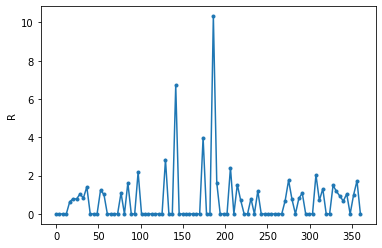

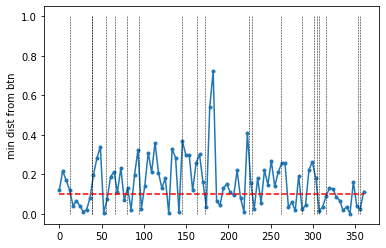

In [294]:
plt.plot(np.linspace(0,1,90)*360,Rs,marker='.')
plt.ylabel('R')
plt.show()

plt.plot(np.linspace(0,1,90)*360,dists,marker='.')
plt.plot([0,360],[0.1,0.1],ls='--',color='red')
for th in train_thetas:
    plt.plot([th/2/np.pi*360,th/2/np.pi*360],[0,1],ls='--',color='black',lw=0.5)
plt.ylabel('min dist from btn')
plt.show()

In [290]:
train_thetas

[2.52299293616753,
 0.969591500857559,
 1.140708900302102,
 3.0029161643653492,
 0.2310405821856491,
 0.6681815597950457,
 1.6523718323579166,
 0.6707626586301276,
 5.261259910639258,
 4.575919047460333,
 3.91796055546683,
 6.213717040553316,
 2.850080279385435,
 6.160270525171928,
 5.325837119068753,
 5.354466268829198,
 1.4029414667225832,
 5.5067320269454,
 3.988463532280372,
 5.016327747526899]

In [270]:
np.array(POSITION)[0,:]
print( np.sqrt( np.sum((np.array(POSITION)[50,:] - btn_test)**2) ) )

0.7887190449893787


TypeError: list indices must be integers or slices, not tuple

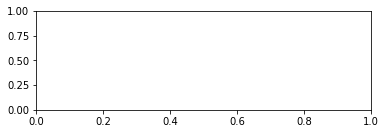

In [104]:
plt.figure()
plt.subplot(211)
plt.plot(POSITION[0,:])
plt.plot(POSITION[1,:])
plt.subplot(212)

plt.plot(context)

In [74]:
TIME_TEST = 1500

par['T'] = TIME_TEST
lttb.T = TIME_TEST

REWARDS = []

for rep in range(20):

    lttb.initialize(par)

    lttb.y_targ = np.zeros((lttb.O,lttb.T))

    targ_test = (np.random.rand(2)-.5)
    btn_test = (np.random.rand(2)-.5)

    trajectory = np.zeros((2,TIME_TEST-1))
    trajectory[:,0] = init

    env.reset (init = init, targ = targ_test, btn = btn_test)

    agen = init

    R = 0

    ACTIONS = []
    POSITION = np.zeros((2,TIME_TEST))

    state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

    #lttb.I_clock[:,0] *= 0

    #state, r, done, agen = env.step ([0,0])
    lttb.I_clock[:,0] = state#lttb.I_clock_collection[cont_index][:,0]

    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    closed_loop = 1

    context = []

    for t in range (TIME_TEST-2):

        if closed_loop:
            lttb.I_clock[:,lttb.t+1] = state
            if np.sqrt( np.sum((agen - btn_test)**2) ) < 0.1:

                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        else:
            lttb.I_clock[:,lttb.t+1] = lttb.I_clock_collection[cont_index][:,lttb.t+1]
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        context.append(lttb.cont)

        lttb.step (apicalFactor = 0)
        action = lttb.Jout@lttb.B_filt[:,t]
        ACTIONS.append(action)

        state, r, done, agen = env.step (action)

        POSITION[:,t] = agen
        R = max (R, r)

        if np.sqrt( np.sum((agen - targ_test)**2) ) < 0.1:
            done = 1

        if done: break
            
    REWARDS.append(R)

    print('R = ' + str(R))

    


R = 0
R = 0
R = 0
R = 0
R = 4.626371807823789
R = 0
R = 10.341577828430156
R = 10.271286194102471
R = 0
R = 5.636280050593238
R = 0
R = 0
R = 0
R = 0
R = 0
R = 4.796671672409694
R = 0
R = 10.042919213210986
R = 0
R = 0


Text(0.5, 0, 'Reward')

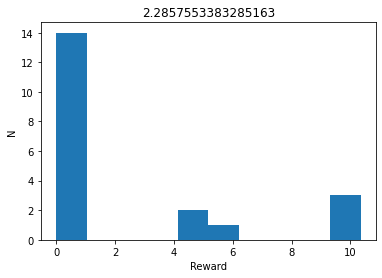

In [75]:
plt.hist(REWARDS)
plt.title(np.array(REWARDS).mean())
plt.ylabel("N")
plt.xlabel("Reward")